In [1]:
import numpy as np
import glob
import os
import pandas as pd
import scipy.signal as signal
import mne
import random
import torchvision
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import DatasetFolder

from mne import preprocessing, Epochs
import utils
import matplotlib.pyplot as plt

## Data pre-processing

### Band pass filtering and events

In [2]:
eeg_file_path = 'data/eeg_data_A/'
eeg_training_files = glob.glob('data/eeg_data_A/A0*T.gdf')

eeg_eval_files = glob.glob(os.path.join(eeg_file_path, 'A0*E.gdf'))

eeg_train_obj, epoch_train_obj = utils.band_pass_filter(eeg_training_files)
eeg_eval_obj, epoch_eval_obj = utils.band_pass_filter(eeg_eval_files)


Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A09T.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-centr

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A06T.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-centr

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A07T.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-centr

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A08T.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-centr

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A09E.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A06E.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A08E.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /run/media/thomas/hdd/repos/eeg-transformer/data/eeg_data_A/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading

/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


data/eeg_data_A/A07E.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
EVENT ID: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped


In [3]:
eeg_data = utils.raw_to_tensor(eeg_train_obj)
eeg_test_data = utils.raw_to_tensor(eeg_eval_obj)
split_size = 1000  

smaller_tensors = []
test_tensors = []

for tensor in eeg_data:  # Assuming eeg_data is your original dataset
    splits = utils.split_tensor(tensor, split_size)
    smaller_tensors.extend(splits)

for tensor in eeg_test_data:  # Assuming eeg_data is your original dataset
    splits = utils.split_tensor(tensor, split_size)
    test_tensors.extend(splits)

print(len(smaller_tensors))

2724


In [4]:

class EEGDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
eeg_data= EEGDataset(smaller_tensors)
eeg_test_data = EEGDataset(test_tensors)


aug_data = []

for tensor in eeg_data:
    aug_data.append(tensor)
    shifted_tensor = utils.time_shift(tensor.clone(), shift=10)
    aug_data.append(shifted_tensor)

    noisy_tensor = utils.add_noise(tensor.clone(), noise_level=0.1)
    aug_data.append(noisy_tensor)

    warped_tensor = utils.time_warp(tensor.clone(), factor=0.8)
    aug_data.append(warped_tensor)



max_length = max(tensor.shape[1] for tensor in aug_data)

def pad_tensor(tensor, max_length):
    padding_size = max_length - tensor.shape[1]
    if padding_size > 0:
        return torch.nn.functional.pad(tensor, (0, padding_size))
    return tensor

padded_tensors = [pad_tensor(torch.tensor(tensor, dtype=torch.float32), max_length) for tensor in aug_data]

aug_data_set = EEGDataset(padded_tensors)

eeg_data = EEGDataset(aug_data_set)

/tmp/ipykernel_332411/1977489221.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensors = [pad_tensor(torch.tensor(tensor, dtype=torch.float32), max_length) for tensor in aug_data]


In [5]:
print(len(eeg_data))

eeg_train_set, eeg_val_set = random_split(eeg_data, [8000,2896]) 


print("Number of items in training set:", len(eeg_train_set))
print("Shape of first item in training set:", eeg_train_set[0].shape)

print("Number of items in validation set:", len(eeg_val_set))
print("Shape of first item in validation set:", eeg_val_set[0].shape)

10896
Number of items in training set: 8000
Shape of first item in training set: torch.Size([25, 1000])
Number of items in validation set: 2896
Shape of first item in validation set: torch.Size([25, 1000])


In [6]:

BATCH_SIZE = 70
train_loader = DataLoader(eeg_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(eeg_val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(eeg_test_data, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 25
nhead = 5  
num_layers = 6  

class ConvNet(nn.Module):
    def __init__(self, dropout_rate = 0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, (1, 4), (1, 1))
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(40, 40, (25, 1), (1, 1))
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        # Assuming the width after conv1 is 1000 - 4 + 1 = 997
        # After conv2, the height is 1
        output_size = 40 * 1 * 997  # 40 channels, height 1, width 997
        self.fc1 = nn.Linear(output_size, embed_size)  # Adjusted for the correct input size
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1) #becomes [N, 1, 25, 1000]
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.elu2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.dropout3(x)
        x = self.fc1(x)
        return x


In [8]:


#transformer = nn.Transformer(d_model=d_model, nhead=nhead).to(device)

conv_net = ConvNet().to(device)
encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead).to(device)
decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead).to(device)


transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
model_params = list(transformer_encoder.parameters()) + list(transformer_decoder.parameters())


/home/thomas/eegtransenv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:

criterion = nn.MSELoss()    
optimizer = optim.SGD(model_params, 
                        lr=0.001, 
                        momentum=0.9)
train_losses = []
val_losses = []
losses = []
n = 1
for epoch in range(10):
    train_loss = 0.0
    #transformer.train()

    for batch in train_loader: 
        src_data = batch
        src_data = src_data.cuda()

        optimizer.zero_grad()
        
        src_data = conv_net(src_data)
       
        memory = transformer_encoder(src_data)
        
        out_batch = transformer_decoder(src_data, memory)
        loss = criterion(out_batch, src_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        n += 1
    
    val_loss = 0.0
    for batch in val_loader:
        src_data = batch
        src_data = src_data.cuda()
        src_data = conv_net(src_data)
    

        memory = transformer_encoder(src_data)
        #print("Validation Decoding...")
        out_batch = transformer_decoder(src_data, memory)
        loss = criterion(out_batch, src_data)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_loss += loss.item()

   

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(train_loader), 
                  val_loss/len(val_loader)))


Epoch: 0 Train Loss: 0.6639262950938681 Val Loss: 0.30209090809027356
Epoch: 1 Train Loss: 0.11380248999466067 Val Loss: 0.06170620432212239
Epoch: 2 Train Loss: 0.0573943214248056 Val Loss: 0.05362456531396934
Epoch: 3 Train Loss: 0.051080713388712506 Val Loss: 0.04832853137382439
Epoch: 4 Train Loss: 0.046313774391360904 Val Loss: 0.044713971249404405
Epoch: 5 Train Loss: 0.04290222000816594 Val Loss: 0.041094400077348665
Epoch: 6 Train Loss: 0.03961381662798964 Val Loss: 0.038963131340486665
Epoch: 7 Train Loss: 0.037159968037968096 Val Loss: 0.036460948265379385
Epoch: 8 Train Loss: 0.03508135320051857 Val Loss: 0.033686675397413116
Epoch: 9 Train Loss: 0.0331398064189631 Val Loss: 0.03237176566783871


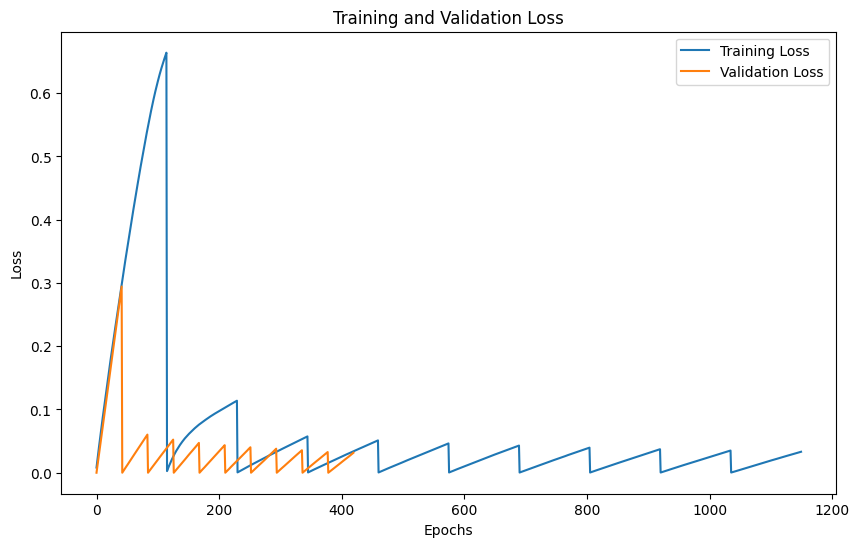

In [10]:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
test_loss = 0.0

with torch.no_grad():  # No gradients needed for testing
    for batch in test_loader:  # Replace 'test_loader' with your test data loader
        src_data = batch
        src_data = src_data.cuda()

        # Forward pass through the model
        src_data = conv_net(src_data)  # If using convolutional network
        memory = transformer_encoder(src_data)
        out_batch = transformer_decoder(src_data, memory)

        # Calculate loss
        loss = criterion(out_batch, src_data)
        test_loss += loss.item()

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.25 GiB. GPU 0 has a total capacty of 5.79 GiB of which 4.19 GiB is free. Including non-PyTorch memory, this process has 984.00 MiB memory in use. Of the allocated memory 543.75 MiB is allocated by PyTorch, and 322.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF